<div style="display: : column; align-items: center; justify-content: center; text-align: center; padding: 20px;"

### **Introduction to Artificial Intelligence (DSC 212)*

## **Name: PRIYAM PANDEY**

</div>


# ======================================================================================

## **DSC212 Research Assignment — Spectral Modularity on the Karate Club Graph**
# ======================================================================================

This project implements a **complete programmatic pipeline** for uncovering community structure in **Zachary’s Karate Club graph** using **recursive spectral modularity partitioning**.
The workflow translates the theoretical idea of modularity maximization into a practical, step-wise computational procedure involving modularity-matrix construction, eigenvector-based bipartitioning, controlled recursion, visualization, and structural-metric tracking.

## **Project Description**

* The pipeline begins by loading the Karate Club graph and constructing the **modularity matrix** for any node subset encountered during recursion.
* For each candidate subset, it computes the **leading eigenvalue and eigenvector** of the symmetrized modularity matrix.
* Nodes are bipartitioned according to the **sign pattern of the leading eigenvector**.
* A split is accepted only if it meets the **minimum community size criterion** and yields a **positive leading eigenvalue**.
* This bipartitioning step is then applied **recursively**, with depth control and detailed logging of each successful subdivision.
* Every intermediate community assignment is captured as a **partition snapshot**.
* Each snapshot is visualized using a **fixed graph layout**, with node colors reflecting the current community structure.
* At every iteration, the pipeline computes within-community structural metrics:

  * degree centrality
  * betweenness centrality
  * closeness centrality
  * clustering coefficient
* These metrics are aggregated across iterations, and **evolution plots** are generated to illustrate how node importance changes as the partitioning hierarchy deepens.
* The project concludes with a summary of the **final community configuration** and a complete log of splits, including their corresponding **leading eigenvalues**.

Overall, this work demonstrates how spectral modularity methods can be turned into a **coherent, reproducible algorithmic workflow**, revealing the emergence of hierarchical community structure through iterative spectral decisions.


# ========================================================================

config

In [8]:
# config.py
OUT_DIR = "results"
MIN_COMMUNITY_SIZE = 3    # minimum nodes required to consider a split
MAX_RECURSION_DEPTH = 20  # maximum recursion depth
VERBOSE = True
SAVE_FIGURES = True       # toggle saving of partition and metric plots
FIG_DPI = 150
RANDOM_SEED = 42


#### utility functions 



In [9]:
# graph_utils.py
import networkx as nx

def load_karate_graph():
    """Return Zachary's Karate Club graph as a simple undirected graph."""
    G = nx.karate_club_graph()
    return nx.Graph(G)


modularity

In [10]:
# modularity.py
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from typing import List, Tuple, Optional
# in modularity.py
def modularity_matrix(G: nx.Graph, nodes: List[int]) -> Tuple[np.ndarray, List[int]]:
    sub = G.subgraph(nodes)
    node_list = list(sub.nodes())
    A = nx.to_numpy_array(sub, nodelist=node_list)
    # degrees taken from the original graph (not subgraph)
    k = np.array([G.degree(n) for n in node_list], dtype=float)
    m_global = G.number_of_edges()
    if m_global == 0:
        B = A.copy()
    else:
        B = A - np.outer(k, k) / (2.0 * m_global)
    return B, node_list

def leading_eigenpair(B: np.ndarray) -> Tuple[Optional[float], Optional[np.ndarray]]:
    n = B.shape[0]
    if n == 0:
        return None, None
    B_sym = (B + B.T) / 2.0
    if n >= 2:
        try:
            eigvals, eigvecs = eigsh(csr_matrix(B_sym), k=1, which="LA")
            return float(eigvals[0]), eigvecs[:, 0]
        except Exception:
            pass
    w, v = np.linalg.eigh(B_sym)
    return float(w[-1]), v[:, -1]


partitioning

In [11]:
# partitioning.py
from typing import List, Dict, Tuple, Optional
import numpy as np
import networkx as nx
# from modularity import modularity_matrix, leading_eigenpair

def bipartition_via_modularity_spectrum(
    G: nx.Graph,
    S: List[int],
    min_size: int = 3
) -> Optional[Tuple[List[int], List[int], float]]:
    """
    Try to split node subset S into S_plus and S_minus using the leading
    eigenvector of the modularity matrix. Return (S_plus, S_minus, lambda_1)
    or None if no valid split.
    """
    if len(S) <= min_size:
        return None

    B, node_list = modularity_matrix(G, S)
    lambda_1, v1 = leading_eigenpair(B)
    if lambda_1 is None or lambda_1 <= 1e-10:
        return None

    signs = np.sign(v1)
    signs[signs == 0] = 1e-9  # treat zeros as positive small to avoid empty groups

    S_plus = [node_list[i] for i in range(len(node_list)) if signs[i] > 0]
    S_minus = [node_list[i] for i in range(len(node_list)) if signs[i] < 0]

    if len(S_plus) < min_size or len(S_minus) < min_size:
        return None

    return S_plus, S_minus, float(lambda_1)


def recursive_spectral_community_detection(
    G: nx.Graph,
    initial_nodes: List[int],
    min_size: int = 3,
    max_depth: int = 20,
    verbose: bool = True
) -> Tuple[Dict[int, int], List[Dict[int, int]], List[Tuple[List[int], List[int], List[int], float]]]:
    """
    Recursively partition starting from initial_nodes.
    Returns:
      - community_label: dict node -> community_id (final labels)
      - partition_history: list of community_label snapshots (after each split)
      - partition_log: list of tuples (parent_set, S_plus, S_minus, lambda_1)
    """
    community_label = {n: 0 for n in initial_nodes}   # initial community id 0
    partition_history = [community_label.copy()]
    stack = [(initial_nodes, 0, 0)]  # (node_subset, community_id, depth)
    next_comm_id = 1
    partition_log = []

    while stack:
        S, cid, depth = stack.pop()
        if depth >= max_depth:
            continue

        res = bipartition_via_modularity_spectrum(G, S, min_size)
        if res is None:
            continue

        S_plus, S_minus, lambda_1 = res
        rid = next_comm_id
        next_comm_id += 1

        # assign labels: keep left group at cid, right group new id rid
        for n in S_plus:
            community_label[n] = cid
        for n in S_minus:
            community_label[n] = rid

        partition_log.append((S, S_plus, S_minus, lambda_1))

        if verbose:
            print(f"Depth {depth}: split community {cid} → {len(S_plus)} + {len(S_minus)} (λ₁={lambda_1:.4f})")

        # push children to stack; keep depth tracking
        stack.extend([(S_plus, cid, depth + 1), (S_minus, rid, depth + 1)])
        partition_history.append(community_label.copy())

    return community_label, partition_history, partition_log


#### evaluation metrics and potting results

metrics


In [12]:
# metrics.py
import networkx as nx
from typing import List, Dict

def compute_local_metrics(G_sub: nx.Graph) -> Dict[str, Dict[int, float]]:
    """
    Compute centrality metrics for the provided subgraph. Returns a dict:
    { 'degree': {node: val}, 'betweenness': {...}, ... }
    """
    return {
        "degree": nx.degree_centrality(G_sub),
        "betweenness": nx.betweenness_centrality(G_sub, normalized=True),
        "closeness": nx.closeness_centrality(G_sub) if nx.is_connected(G_sub) else {n: 0.0 for n in G_sub.nodes()},
        "clustering": nx.clustering(G_sub)
    }


def track_metrics_over_partitions(G, partition_history: List[Dict[int, int]]):
    """
    For each partition snapshot, compute local metrics within each community and
    aggregate them into per-iteration metric dictionaries.
    Returns a list of iteration-metric dictionaries.
    """
    iterations = []
    for part in partition_history:
        iter_metrics = {"degree": {}, "betweenness": {}, "closeness": {}, "clustering": {}, "partition": part.copy()}
        # build communities from labels
        communities = {}
        for node, cid in part.items():
            communities.setdefault(cid, []).append(node)

        for cid, nodes in communities.items():
            subG = G.subgraph(nodes)
            local = compute_local_metrics(subG)
            # local metrics are keyed by node; merge into iter_metrics
            for metric_name, metric_vals in local.items():
                iter_metrics[metric_name].update(metric_vals)

        iterations.append(iter_metrics)
    return iterations


visualization


In [13]:
# visualization.py
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib import cm
from typing import Dict, List
# from config import SAVE_FIGURES, OUT_DIR, FIG_DPI

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "font.size": 10
})

def _ensure_outdir():
    os.makedirs(OUT_DIR, exist_ok=True)

def draw_partition(
    G: nx.Graph,
    community_label: Dict[int, int],
    pos: Dict[int, tuple] = None,
    title: str = None,
    filename: str = None,
    node_size_base: int = 400
):
    """
    Draw the graph with nodes colored by community_label.
    pos: precomputed layout dictionary; if None, creates spring layout with fixed seed.
    """
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    # map community ids to 0..k-1
    unique_labels = sorted(set(community_label.values()))
    label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
    colors = [label_to_idx[community_label[n]] for n in G.nodes()]

    cmap = cm.get_cmap("tab10", max(3, len(unique_labels)))
    degrees = dict(G.degree())
    node_sizes = [node_size_base * (0.6 + 0.4 * (degrees[n] / max(1, max(degrees.values())))) for n in G.nodes()]

    plt.figure(figsize=(7, 6))
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
    nodes_drawn = nx.draw_networkx_nodes(
        G, pos, node_color=colors, cmap=cmap,
        node_size=node_sizes, linewidths=0.8, edgecolors='k'
    )
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(title or "Community partition")
    plt.axis("off")

    # create legend for communities
    handles = []
    for lab, idx in label_to_idx.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=cmap(idx), markersize=8, markeredgecolor='k', label=f"c{lab}"))
    plt.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left")

    if filename and SAVE_FIGURES:
        _ensure_outdir()
        plt.savefig(os.path.join(OUT_DIR, filename), bbox_inches="tight", dpi=FIG_DPI)
    plt.show()
    return pos


def plot_metric_evolution(metrics_history: List[Dict], metric_name: str, highlight_nodes: List[int] = None, filename: str = None):
    """
    Plot metric evolution over iterations for each node.
    highlight_nodes: list of node ids to emphasize (e.g., leaders).
    """
    iters = list(range(len(metrics_history)))
    nodes = sorted(metrics_history[0][metric_name].keys())

    plt.figure(figsize=(10, 6))
    for node in nodes:
        vals = [m[metric_name].get(node, 0.0) for m in metrics_history]
        if highlight_nodes and node in highlight_nodes:
            plt.plot(iters, vals, linewidth=2.2, linestyle='--', label=f"Node {node}")
        else:
            plt.plot(iters, vals, linewidth=0.8, alpha=0.6)

    plt.xlabel("Iteration")
    plt.ylabel(metric_name.capitalize())
    plt.title(f"Evolution of {metric_name.capitalize()}")
    if highlight_nodes:
        plt.legend(loc="best")
    plt.grid(alpha=0.3)

    if filename and SAVE_FIGURES:
        _ensure_outdir()
        plt.savefig(os.path.join(OUT_DIR, filename), bbox_inches="tight", dpi=FIG_DPI)
    plt.show()


#### main script 


main

Loaded Karate Club: n=34, m=78
Depth 0: split community 0 → 18 + 16 (λ₁=17.1074)


/var/folders/z6/4z3b7f1d38db3t0frgwjyknh0000gn/T/ipykernel_59109/1066294320.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", max(3, len(unique_labels)))


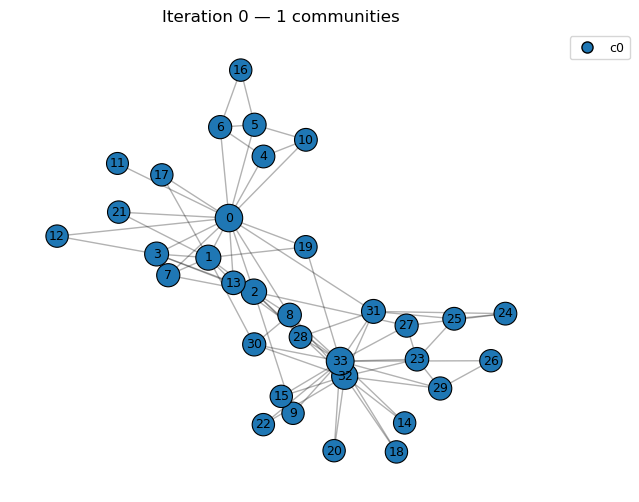

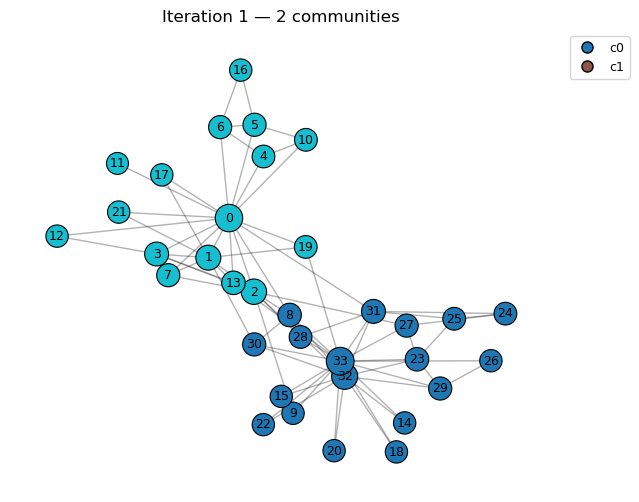

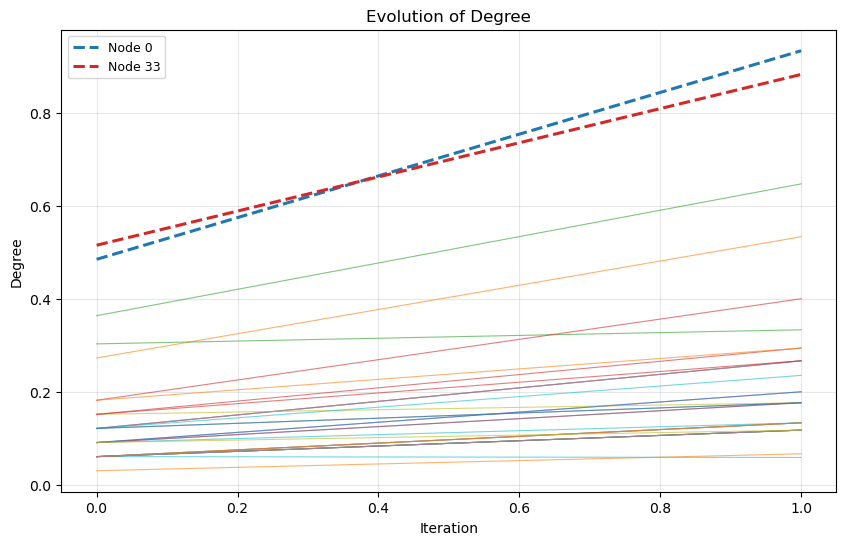

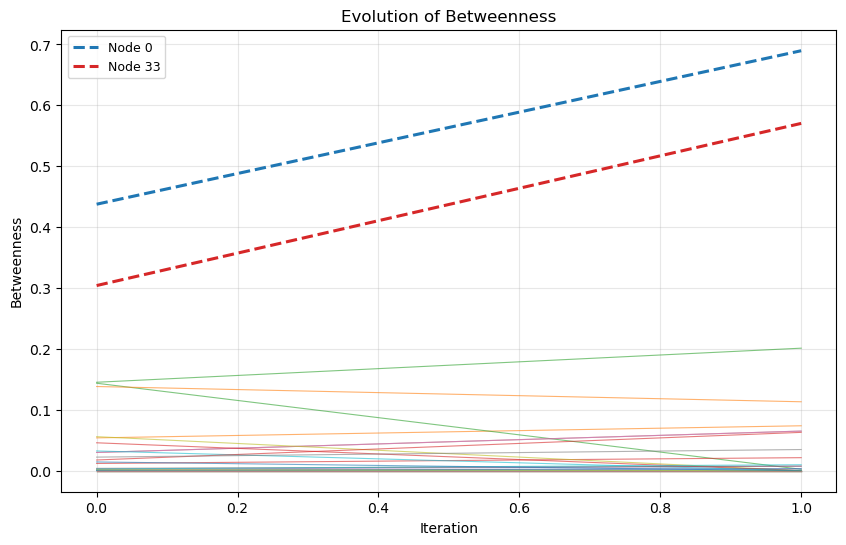

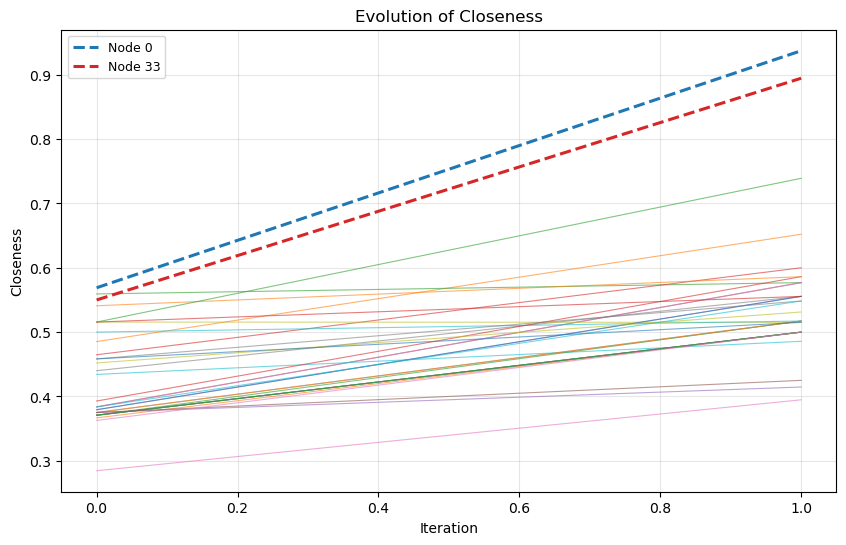

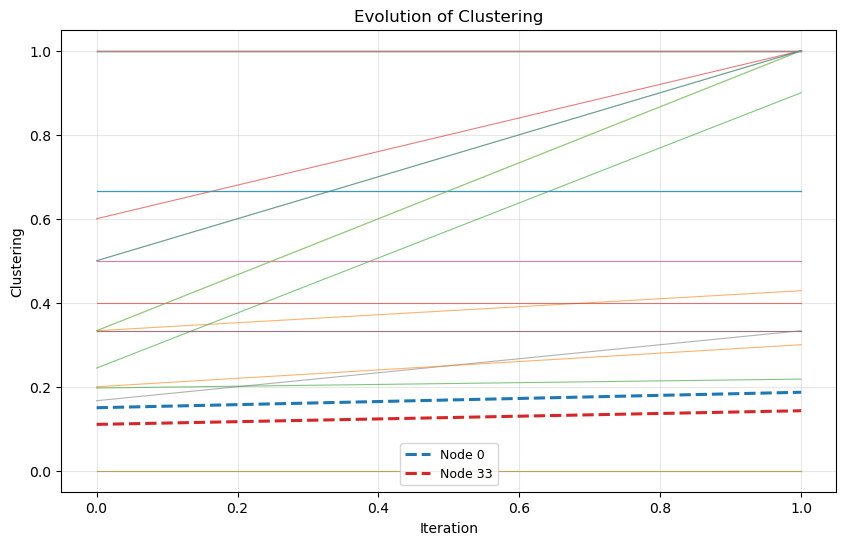


Final communities (id: nodes):
  c0: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  c1: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]

Partition log (parent size -> split sizes -> lambda_1):
 parent(34) -> 18 + 16 (λ₁=17.1074)


In [14]:
# main.py
import os

import random
random.seed(RANDOM_SEED)

def run_experiment():
    G = load_karate_graph()
    nodes = list(G.nodes())
    print(f"Loaded Karate Club: n={G.number_of_nodes()}, m={G.number_of_edges()}")

    community_label, partition_history, partition_log = recursive_spectral_community_detection(
        G,
        initial_nodes=nodes,
        min_size=MIN_COMMUNITY_SIZE,
        max_depth=MAX_RECURSION_DEPTH,
        verbose=VERBOSE
    )

    # visual: partitions over time
    pos = None
    for i, snapshot in enumerate(partition_history):
        title = f"Iteration {i} — {len(set(snapshot.values()))} communities"
        filename = f"partition_iter_{i}.png"
        pos = draw_partition(G, snapshot, pos=pos, title=title, filename=filename)

    # metrics
    metrics_history = track_metrics_over_partitions(G, partition_history)

    # pick leaders to highlight (common in Karate: 0 and 33)
    leaders = [0, 33] if 0 in G and 33 in G else sorted(G.nodes())[:2]

    for metric in ["degree", "betweenness", "closeness", "clustering"]:
        filename = f"{metric}_evolution.png"
        plot_metric_evolution(metrics_history, metric, highlight_nodes=leaders, filename=filename)

    # short result summary
    final_partition = partition_history[-1]
    communities = {}
    for node, cid in final_partition.items():
        communities.setdefault(cid, []).append(node)

    print("\nFinal communities (id: nodes):")
    for cid, nodes in sorted(communities.items()):
        print(f"  c{cid}: {sorted(nodes)}")

    print("\nPartition log (parent size -> split sizes -> lambda_1):")
    for parent, s_plus, s_minus, lam in partition_log:
        print(f" parent({len(parent)}) -> {len(s_plus)} + {len(s_minus)} (λ₁={lam:.4f})")

if __name__ == "__main__":
    run_experiment()


# =======================================================================